In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from loss_function import CombinedLoss
from train_test import train_model, train_model_r2
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets
from visualization import plot_mean_power_spectrum
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders
from qualitative_eval import mse, r2_score, pearson_corr

In [3]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
# import gcm_filters
import random

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Helper functions

In [4]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

# Data Pre-processing

In [5]:
ds_HR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_LR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_HF_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

# Case: u_rel Super-Resolution, MSELoss

In [6]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='u_relative', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [7]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_urel_norm_global.pth',
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 78 with best r2 values [0.9968550205230713, 0.9973013997077942, 0.9970247149467468, 0.9973343014717102, 0.997344970703125]
Epoch 79, Train Loss: 1.931e-04, Val Loss: 5.632e-05, Val R²: 0.9972, Epoch Time: 29.89s
Patience counter: 1/30
Epoch 80, Train Loss: 2.089e-04, Val Loss: 5.183e-05, Val R²: 0.9975, Epoch Time: 31.15s
Patience counter: 2/30
Epoch 81, Train Loss: 1.861e-04, Val Loss: 6.013e-05, Val R²: 0.9971, Epoch Time: 31.25s
Patience counter: 3/30
Epoch 82, Train Loss: 2.209e-04, Val Loss: 5.827e-05, Val R²: 0.9971, Epoch Time: 30.80s
Patience counter: 4/30
Epoch 83, Train Loss: 1.664e-04, Val Loss: 9.109e-05, Val R²: 0.9955, Epoch Time: 31.10s
Patience counter: 5/30
Epoch 84, Train Loss: 1.848e-04, Val Loss: 6.571e-05, Val R²: 0.9968, Epoch Time: 31.10s
Patience counter: 6/30
Epoch 85, Train Loss: 1.788e-04, Val Loss: 8.108e-05, Val R²: 0.9960, Epoch Time: 30.99s
Patience counter: 7/30
Epoch 86, Train Loss: 1.621e-04, Val Loss: 

In [8]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_urel_norm_global.pth') #'./model_case_urel_norm.pth')
sr_pred

Loaded model parameters from ./model_case_urel_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.4194017 , 0.41022468, 0.4182523 , ..., 0.47405624,
         0.46686357, 0.47028744],
        [0.4075333 , 0.44023705, 0.40345973, ..., 0.4798839 ,
         0.4731552 , 0.46610832],
        [0.4103945 , 0.41617417, 0.42538464, ..., 0.46430087,
         0.47602397, 0.4654094 ],
        ...,
        [0.3335505 , 0.33600122, 0.3488951 , ..., 0.40357405,
         0.40650618, 0.3955291 ],
        [0.32149363, 0.3163892 , 0.33132252, ..., 0.40804553,
         0.40129074, 0.39388287],
        [0.35854915, 0.3259708 , 0.34492666, ..., 0.40867078,
         0.39755446, 0.40144455]],

       [[0.59902793, 0.5988779 , 0.6157907 , ..., 0.7697393 ,
         0.78756124, 0.7641797 ],
        [0.6142948 , 0.60204124, 0.59785146, ..., 0.765321  ,
         0.75755614, 0.7698197 ],
        [0.6018162 , 0.6148021 , 0.60083437, ..., 0.7675143 ,
         0.7931984 , 0.76774067],
...
        [0.49748892, 0.5143383 , 0.50554246, ..., 0.5882106 ,
         0.58190656, 0.5787016 ],
        [0.48176926, 0.50921637, 0.50143915, ..., 0.5817087 ,
         0.573453  , 0.5802656 ],
        [0.49213636, 0.4906587 , 0.5018589 , ..., 0.5816781 ,
         0.5926656 , 0.591676  ]],

       [[0.36839467, 0.3549243 , 0.36239237, ..., 0.33263105,
         0.31914198, 0.3352611 ],
        [0.34795487, 0.36245275, 0.3512708 , ..., 0.32208693,
         0.32313132, 0.33018085],
        [0.36115164, 0.36342043, 0.37737447, ..., 0.31857473,
         0.3012362 , 0.35876417],
        ...,
        [0.35711688, 0.3725214 , 0.38242206, ..., 0.44003707,
         0.46511483, 0.4654463 ],
        [0.3553995 , 0.3597061 , 0.35874707, ..., 0.48538238,
         0.49067438, 0.48008072],
        [0.38450783, 0.36314583, 0.36858654, ..., 0.4675514 ,
         0.46649975, 0.4621842 ]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 8023 7026 2149 4749 3081 ... 1290 7573 7222 4659
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [9]:
r2_scores_urel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_urel)
best_r2 = r2_scores_urel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9990 at index 860


In [10]:
min_val, max_val = norm_stats
urel_HR_test = HR_test * (max_val - min_val) + min_val
urel_LR_test = LR_test * (max_val - min_val) + min_val
urel_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: v_rel Super-Resolution, MSELoss

In [11]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='v_relative', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_vrel_norm_global.pth',
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 4.994e-04, Val Loss: 8.604e-05, Val R²: 0.9922, Epoch Time: 31.75s
Model saved at epoch 1
Epoch 2, Train Loss: 3.686e-04, Val Loss: 7.506e-05, Val R²: 0.9932, Epoch Time: 30.96s
Model saved at epoch 2
Epoch 3, Train Loss: 3.580e-04, Val Loss: 3.737e-04, Val R²: 0.9661, Epoch Time: 30.76s
Model saved at epoch 3
Epoch 4, Train Loss: 3.637e-04, Val Loss: 2.108e-04, Val R²: 0.9809, Epoch Time: 31.18s
Model saved at epoch 4
Epoch 5, Train Loss: 3.190e-04, Val Loss: 7.359e-05, Val R²: 0.9933, Epoch Time: 31.04s
Model saved at epoch 5
Epoch 6, Train Loss: 3.368e-04, Val Loss: 1.134e-04, Val R²: 0.9897, Epoch Time: 30.94s
Model saved at epoch 6
Epoch 7, Train Loss: 3.186e-04, Val Loss: 2.484e-04, Val R²: 0.9774, Epoch Time: 31.03s
Model saved at epoch 7
Epoch 8, Train Loss: 3.433e-04, Val Loss: 7.592e-05, Val R²: 0.9931, Epoch Time: 31.03s
Model saved at epoch 8
Epoch 9, Train Loss: 3.375e-04, Val Loss: 1.365e-04, Val R²: 0.9877, Epoch Time: 3

In [12]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_vrel_norm_global.pth') # './model_case_vrel_norm.pth')
sr_pred

Loaded model parameters from ./model_case_vrel_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.5685721 , 0.5690852 , 0.5731012 , ..., 0.56832534,
         0.57667184, 0.56874937],
        [0.58267486, 0.5696982 , 0.5606649 , ..., 0.5693474 ,
         0.57157564, 0.5803534 ],
        [0.5708263 , 0.5799202 , 0.57363266, ..., 0.57014346,
         0.5720428 , 0.5774857 ],
        ...,
        [0.543637  , 0.5388418 , 0.53296596, ..., 0.54342264,
         0.5417733 , 0.54198325],
        [0.54697496, 0.5398636 , 0.53758293, ..., 0.53759784,
         0.5389441 , 0.54219353],
        [0.54763454, 0.5353147 , 0.5389855 , ..., 0.5360493 ,
         0.5407567 , 0.54835725]],

       [[0.39995372, 0.39257684, 0.39769322, ..., 0.27923495,
         0.2521801 , 0.28671092],
        [0.39795393, 0.4005257 , 0.39368993, ..., 0.27291745,
         0.25368065, 0.2677445 ],
        [0.40180126, 0.4021597 , 0.4006796 , ..., 0.26931638,
         0.2779746 , 0.28021297],
...
        [0.6269937 , 0.6231594 , 0.6344596 , ..., 0.5011449 ,
         0.49847597, 0.49908113],
        [0.6220692 , 0.6188448 , 0.6320601 , ..., 0.49790674,
         0.5055124 , 0.507587  ],
        [0.6093506 , 0.605884  , 0.63267213, ..., 0.5006405 ,
         0.5040656 , 0.50590265]],

       [[0.3903357 , 0.38491672, 0.39001462, ..., 0.43191743,
         0.4193632 , 0.42450768],
        [0.38767135, 0.39052272, 0.38617814, ..., 0.43004078,
         0.42577517, 0.43260974],
        [0.38707596, 0.39360997, 0.38743708, ..., 0.43973893,
         0.42726767, 0.4329983 ],
        ...,
        [0.48333573, 0.479747  , 0.46198434, ..., 0.46636337,
         0.44652683, 0.45312685],
        [0.4732358 , 0.48532206, 0.47561538, ..., 0.45405507,
         0.45390397, 0.46102464],
        [0.4782815 , 0.4749574 , 0.4773761 , ..., 0.45753825,
         0.4562872 , 0.4573465 ]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 1648 3089 1837 5125 1891 ... 5340 1991 7918 7346
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [13]:
r2_scores_vrel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_vrel)
best_r2 = r2_scores_vrel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9992 at index 12


In [14]:
min_val, max_val = norm_stats
vrel_HR_test = HR_test * (max_val - min_val) + min_val
vrel_LR_test = LR_test * (max_val - min_val) + min_val
vrel_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: t_ref Super-Resolution, MSELoss

In [15]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='t_ref', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_tref_norm_global.pth',
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 2.520e-03, Val Loss: 9.302e-05, Val R²: 0.9972, Epoch Time: 31.61s
Model saved at epoch 1
Epoch 2, Train Loss: 3.956e-04, Val Loss: 2.278e-04, Val R²: 0.9933, Epoch Time: 30.89s
Model saved at epoch 2
Epoch 3, Train Loss: 2.553e-04, Val Loss: 1.740e-04, Val R²: 0.9948, Epoch Time: 30.72s
Model saved at epoch 3
Epoch 4, Train Loss: 2.334e-04, Val Loss: 7.273e-04, Val R²: 0.9782, Epoch Time: 31.12s
Model saved at epoch 4
Epoch 5, Train Loss: 2.152e-04, Val Loss: 3.964e-05, Val R²: 0.9989, Epoch Time: 30.98s
Model saved at epoch 5
Epoch 6, Train Loss: 1.431e-04, Val Loss: 2.256e-04, Val R²: 0.9933, Epoch Time: 30.83s
Model saved at epoch 6
Epoch 7, Train Loss: 1.796e-04, Val Loss: 7.924e-05, Val R²: 0.9976, Epoch Time: 31.01s
Model saved at epoch 7
Epoch 8, Train Loss: 1.698e-04, Val Loss: 3.018e-04, Val R²: 0.9909, Epoch Time: 30.96s
Model saved at epoch 8
Epoch 9, Train Loss: 1.577e-04, Val Loss: 7.146e-05, Val R²: 0.9979, Epoch Time: 3

In [16]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_tref_norm_global.pth')
sr_pred

Loaded model parameters from ./model_case_tref_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.8787631 , 0.8847044 , 0.8779184 , ..., 0.84316134,
         0.83829   , 0.8424796 ],
        [0.8904151 , 0.8822941 , 0.87616366, ..., 0.84084   ,
         0.8408156 , 0.8533568 ],
        [0.8693533 , 0.8643791 , 0.8747784 , ..., 0.84943753,
         0.84409386, 0.84813595],
        ...,
        [0.60306734, 0.6052048 , 0.6095892 , ..., 0.6088581 ,
         0.620984  , 0.6132714 ],
        [0.5813471 , 0.5797093 , 0.5921193 , ..., 0.61675584,
         0.58144015, 0.6007687 ],
        [0.607469  , 0.60584086, 0.5869585 , ..., 0.58995885,
         0.59990233, 0.6167813 ]],

       [[0.70944875, 0.70318717, 0.70102537, ..., 0.70704144,
         0.70103675, 0.7197717 ],
        [0.6946258 , 0.71253526, 0.7033565 , ..., 0.714873  ,
         0.7249176 , 0.71749014],
        [0.7402118 , 0.74999064, 0.69206643, ..., 0.7223317 ,
         0.7130709 , 0.72266376],
...
        [0.89443034, 0.8842011 , 0.89351225, ..., 0.8614778 ,
         0.85473883, 0.85547316],
        [0.9065967 , 0.8879897 , 0.8928611 , ..., 0.8613475 ,
         0.8643281 , 0.85284716],
        [0.89424974, 0.88700145, 0.8946982 , ..., 0.86261964,
         0.86352164, 0.8589175 ]],

       [[0.50196487, 0.474343  , 0.48154736, ..., 0.3795212 ,
         0.3598113 , 0.3998647 ],
        [0.4801498 , 0.4712211 , 0.4767905 , ..., 0.3756371 ,
         0.36696184, 0.36640024],
        [0.4932555 , 0.47533357, 0.47772157, ..., 0.37340575,
         0.37922668, 0.3884957 ],
        ...,
        [0.54301125, 0.54502887, 0.5469207 , ..., 0.51503605,
         0.52484596, 0.51796424],
        [0.5270828 , 0.51676184, 0.532036  , ..., 0.52689934,
         0.5148481 , 0.5133934 ],
        [0.5592111 , 0.556126  , 0.54213   , ..., 0.514743  ,
         0.5172711 , 0.527419  ]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 251 1286 3312 2020 8077 ... 3516 2285 808 2878
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [17]:
r2_scores_tref = r2_per_sample(HR_test.values, sr_pred.values)
r2_scores_tref

array([0.99804795, 0.95599908, 0.99321616, ..., 0.9953562 , 0.94907749,
       0.99169785], shape=(1314,))

In [18]:
best_index = np.argmax(r2_scores_tref)
best_r2 = r2_scores_tref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9989 at index 634


In [19]:
min_val, max_val = norm_stats
tref_HR_test = HR_test * (max_val - min_val) + min_val
tref_LR_test = LR_test * (max_val - min_val) + min_val
tref_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: q_ref Super-Resolution, MSELoss

In [20]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='q_ref', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_qref_norm_global.pth',
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 9.935e-04, Val Loss: 1.908e-04, Val R²: 0.9966, Epoch Time: 31.68s
Model saved at epoch 1
Epoch 2, Train Loss: 3.936e-04, Val Loss: 1.144e-04, Val R²: 0.9979, Epoch Time: 30.88s
Model saved at epoch 2
Epoch 3, Train Loss: 3.770e-04, Val Loss: 8.899e-04, Val R²: 0.9840, Epoch Time: 30.75s
Model saved at epoch 3
Epoch 4, Train Loss: 4.048e-04, Val Loss: 3.123e-04, Val R²: 0.9944, Epoch Time: 31.13s
Model saved at epoch 4
Epoch 5, Train Loss: 2.984e-04, Val Loss: 2.194e-04, Val R²: 0.9960, Epoch Time: 30.96s
Model saved at epoch 5
Epoch 6, Train Loss: 3.597e-04, Val Loss: 1.616e-04, Val R²: 0.9971, Epoch Time: 30.88s
Model saved at epoch 6
Epoch 7, Train Loss: 3.137e-04, Val Loss: 1.057e-04, Val R²: 0.9981, Epoch Time: 31.00s
Model saved at epoch 7
Epoch 8, Train Loss: 2.878e-04, Val Loss: 1.067e-04, Val R²: 0.9981, Epoch Time: 30.99s
Model saved at epoch 8
Epoch 9, Train Loss: 3.088e-04, Val Loss: 1.760e-04, Val R²: 0.9969, Epoch Time: 3

In [21]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_qref_norm_global.pth')
sr_pred

Loaded model parameters from ./model_case_qref_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.14351194, 0.06787501, 0.05087198, ..., 0.0662438 ,
         0.07279886, 0.13494024],
        [0.10352807, 0.06357735, 0.05250837, ..., 0.06666163,
         0.07521928, 0.08547934],
        [0.07606039, 0.04972862, 0.04345463, ..., 0.06709319,
         0.06288317, 0.07730647],
        ...,
        [0.11996233, 0.12592058, 0.11221366, ..., 0.12456759,
         0.13018687, 0.12300128],
        [0.1282998 , 0.12265091, 0.12249373, ..., 0.13836177,
         0.13840242, 0.15752025],
        [0.16970046, 0.13221942, 0.12204417, ..., 0.14270474,
         0.1555199 , 0.19266503]],

       [[0.33868223, 0.33827686, 0.34073552, ..., 0.36099398,
         0.33751783, 0.36727315],
        [0.33022305, 0.33916563, 0.342929  , ..., 0.3558128 ,
         0.35373265, 0.35987544],
        [0.34735873, 0.3497364 , 0.3517322 , ..., 0.36314532,
         0.37741676, 0.35709387],
...
        [0.18499787, 0.2031011 , 0.18615504, ..., 0.19989318,
         0.20941089, 0.20311047],
        [0.18209259, 0.19734849, 0.1974537 , ..., 0.20628303,
         0.20774904, 0.21548995],
        [0.21552053, 0.19025579, 0.1835622 , ..., 0.20229742,
         0.20537905, 0.2383137 ]],

       [[0.47220278, 0.48690152, 0.47918767, ..., 0.37948036,
         0.35522234, 0.38243365],
        [0.479765  , 0.4832071 , 0.48719746, ..., 0.37923086,
         0.37854546, 0.3809144 ],
        [0.50349826, 0.5013767 , 0.48606974, ..., 0.37822968,
         0.39209008, 0.37821913],
        ...,
        [0.723467  , 0.7317966 , 0.74377185, ..., 0.7615401 ,
         0.7480525 , 0.74701947],
        [0.73231506, 0.73232186, 0.7445324 , ..., 0.76552373,
         0.76166314, 0.76721877],
        [0.71497536, 0.74189276, 0.7453486 , ..., 0.7692694 ,
         0.7501626 , 0.7479705 ]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 7165 8577 6051 1415 2109 ... 1273 6219 6488 8212
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [22]:
r2_scores_qref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_qref)
best_r2 = r2_scores_qref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9987 at index 725


In [23]:
min_val, max_val = norm_stats
qref_HR_test = HR_test * (max_val - min_val) + min_val
qref_LR_test = LR_test * (max_val - min_val) + min_val
qref_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: SLP Super-Resolution, MSELoss

In [24]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='slp', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_slp_norm_global.pth',
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 7.386e-04, Val Loss: 2.047e-04, Val R²: 0.9836, Epoch Time: 31.67s
Model saved at epoch 1
Epoch 2, Train Loss: 2.559e-04, Val Loss: 1.608e-04, Val R²: 0.9867, Epoch Time: 30.89s
Model saved at epoch 2
Epoch 3, Train Loss: 2.685e-04, Val Loss: 2.025e-04, Val R²: 0.9838, Epoch Time: 30.68s
Model saved at epoch 3
Epoch 4, Train Loss: 2.060e-04, Val Loss: 2.886e-04, Val R²: 0.9764, Epoch Time: 31.12s
Model saved at epoch 4
Epoch 5, Train Loss: 1.876e-04, Val Loss: 4.218e-04, Val R²: 0.9652, Epoch Time: 30.98s
Model saved at epoch 5
Epoch 6, Train Loss: 1.606e-04, Val Loss: 5.522e-05, Val R²: 0.9956, Epoch Time: 30.84s
Model saved at epoch 6
Epoch 7, Train Loss: 1.993e-04, Val Loss: 2.250e-04, Val R²: 0.9818, Epoch Time: 30.96s
Model saved at epoch 7
Epoch 8, Train Loss: 2.180e-04, Val Loss: 3.369e-04, Val R²: 0.9724, Epoch Time: 30.97s
Model saved at epoch 8
Epoch 9, Train Loss: 1.691e-04, Val Loss: 3.273e-04, Val R²: 0.9731, Epoch Time: 3

In [25]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_slp_norm_global.pth')
sr_pred

Loaded model parameters from ./model_case_slp_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.78894407, 0.8069052 , 0.8054919 , ..., 0.83288896,
         0.83397764, 0.8101511 ],
        [0.8083367 , 0.81188065, 0.7893593 , ..., 0.8453376 ,
         0.83297336, 0.8364812 ],
        [0.7993653 , 0.828802  , 0.79694414, ..., 0.84650517,
         0.837599  , 0.8342903 ],
        ...,
        [0.8950214 , 0.92749536, 0.8963615 , ..., 0.9320565 ,
         0.9447966 , 0.9311442 ],
        [0.9142952 , 0.9063162 , 0.8934519 , ..., 0.94458115,
         0.93805707, 0.92401385],
        [0.8858988 , 0.89363277, 0.9108935 , ..., 0.9533486 ,
         0.93606865, 0.9166269 ]],

       [[0.7414122 , 0.7411373 , 0.7424787 , ..., 0.7612283 ,
         0.7583442 , 0.75417286],
        [0.7473089 , 0.74154174, 0.7319993 , ..., 0.76723826,
         0.75738335, 0.7646687 ],
        [0.74349684, 0.75657105, 0.7336055 , ..., 0.7698708 ,
         0.75818574, 0.7670912 ],
...
        [0.74285084, 0.7371953 , 0.74417007, ..., 0.7462487 ,
         0.7454114 , 0.75255996],
        [0.74304307, 0.735258  , 0.73576343, ..., 0.7573564 ,
         0.7376836 , 0.7462175 ],
        [0.7364809 , 0.746773  , 0.73491836, ..., 0.7500764 ,
         0.7340932 , 0.7459978 ]],

       [[0.7344222 , 0.7319583 , 0.7337152 , ..., 0.7541397 ,
         0.75078905, 0.7482993 ],
        [0.738352  , 0.7319829 , 0.72409105, ..., 0.7598015 ,
         0.750264  , 0.7575966 ],
        [0.73547107, 0.74639994, 0.72845554, ..., 0.7624034 ,
         0.7516892 , 0.7609697 ],
        ...,
        [0.65911824, 0.6624088 , 0.68492377, ..., 0.687256  ,
         0.66358596, 0.6692174 ],
        [0.6582    , 0.6615491 , 0.6585544 , ..., 0.6781745 ,
         0.6925501 , 0.6742387 ],
        [0.6598559 , 0.6633172 , 0.6584995 , ..., 0.6804476 ,
         0.67888254, 0.6808221 ]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 3889 5048 4359 594 1111 ... 4308 23 991 777 4547
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [26]:
r2_scores_slp = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_slp)
best_r2 = r2_scores_slp[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9994 at index 303


In [27]:
min_val, max_val = norm_stats
slp_HR_test = HR_test * (max_val - min_val) + min_val
slp_LR_test = LR_test * (max_val - min_val) + min_val
slp_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: SST Super-Resolution, MSELoss

In [28]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='surface_temp', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_sst_norm_global.pth',
            n_epochs=2000, patience=30, delta=1e-3) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 9.543e-04, Val Loss: 4.487e-04, Val R²: 0.9935, Epoch Time: 31.68s
Model saved at epoch 1
Epoch 2, Train Loss: 5.325e-04, Val Loss: 3.529e-04, Val R²: 0.9949, Epoch Time: 30.85s
Model saved at epoch 2
Epoch 3, Train Loss: 3.975e-04, Val Loss: 3.736e-04, Val R²: 0.9946, Epoch Time: 30.74s
Model saved at epoch 3
Epoch 4, Train Loss: 4.456e-04, Val Loss: 4.206e-04, Val R²: 0.9941, Epoch Time: 31.16s
Model saved at epoch 4
Epoch 5, Train Loss: 3.216e-04, Val Loss: 4.045e-04, Val R²: 0.9943, Epoch Time: 30.94s
Model saved at epoch 5
Epoch 6, Train Loss: 3.020e-04, Val Loss: 2.193e-04, Val R²: 0.9968, Epoch Time: 30.93s
Model saved at epoch 6
Epoch 7, Train Loss: 2.896e-04, Val Loss: 1.911e-04, Val R²: 0.9972, Epoch Time: 31.00s
Model saved at epoch 7
Epoch 8, Train Loss: 2.911e-04, Val Loss: 1.908e-04, Val R²: 0.9972, Epoch Time: 31.00s
Model saved at epoch 8
Epoch 9, Train Loss: 2.862e-04, Val Loss: 2.366e-04, Val R²: 0.9966, Epoch Time: 3

In [29]:
device = torch.device("cuda")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_sst_norm_global.pth')
sr_pred

Loaded model parameters from ./model_case_sst_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.6644685 , 0.65714324, 0.6476375 , ..., 0.6262039 ,
         0.62790966, 0.63199043],
        [0.667583  , 0.65588117, 0.6521337 , ..., 0.6288494 ,
         0.630849  , 0.6409284 ],
        [0.6727341 , 0.67631185, 0.65518796, ..., 0.6419082 ,
         0.61943626, 0.63846207],
        ...,
        [0.4705497 , 0.46713287, 0.4942148 , ..., 0.43566683,
         0.44897205, 0.4033841 ],
        [0.4623224 , 0.45670646, 0.46117222, ..., 0.42309535,
         0.4051233 , 0.42140177],
        [0.46845776, 0.47584558, 0.45743525, ..., 0.4090603 ,
         0.41552895, 0.4221566 ]],

       [[0.8284329 , 0.8311032 , 0.8314626 , ..., 0.7710265 ,
         0.7685305 , 0.76305306],
        [0.83910906, 0.8337194 , 0.8232751 , ..., 0.7649479 ,
         0.76002526, 0.7715759 ],
        [0.8270347 , 0.83851624, 0.8370545 , ..., 0.76267564,
         0.7536124 , 0.7799572 ],
...
        [0.16489533, 0.15295808, 0.16479602, ..., 0.38773513,
         0.39798748, 0.36711308],
        [0.18336976, 0.1607368 , 0.16455883, ..., 0.3930832 ,
         0.3742203 , 0.37729642],
        [0.25437924, 0.19645518, 0.17954697, ..., 0.36992806,
         0.37819433, 0.3874678 ]],

       [[0.87971663, 0.8832432 , 0.8875005 , ..., 0.9286033 ,
         0.923898  , 0.9129634 ],
        [0.8950567 , 0.8915974 , 0.8814405 , ..., 0.933493  ,
         0.92798686, 0.93308425],
        [0.87898815, 0.89000404, 0.8994043 , ..., 0.92416835,
         0.9447161 , 0.9635999 ],
        ...,
        [0.7577696 , 0.7768676 , 0.7632401 , ..., 0.85987437,
         0.85775363, 0.8528707 ],
        [0.76333845, 0.74656534, 0.76151884, ..., 0.86854947,
         0.8604777 , 0.8622118 ],
        [0.7562164 , 0.7746568 , 0.7672237 , ..., 0.8672261 ,
         0.84930074, 0.84444404]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 3236 197 6989 7409 3309 ... 627 7848 404 7726
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [30]:
r2_scores_sst = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_sst)
best_r2 = r2_scores_sst[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9963 at index 266


In [31]:
min_val, max_val = norm_stats
sst_HR_test = HR_test * (max_val - min_val) + min_val
sst_LR_test = LR_test * (max_val - min_val) + min_val
sst_sr_pred = sr_pred * (max_val - min_val) + min_val

# Figures

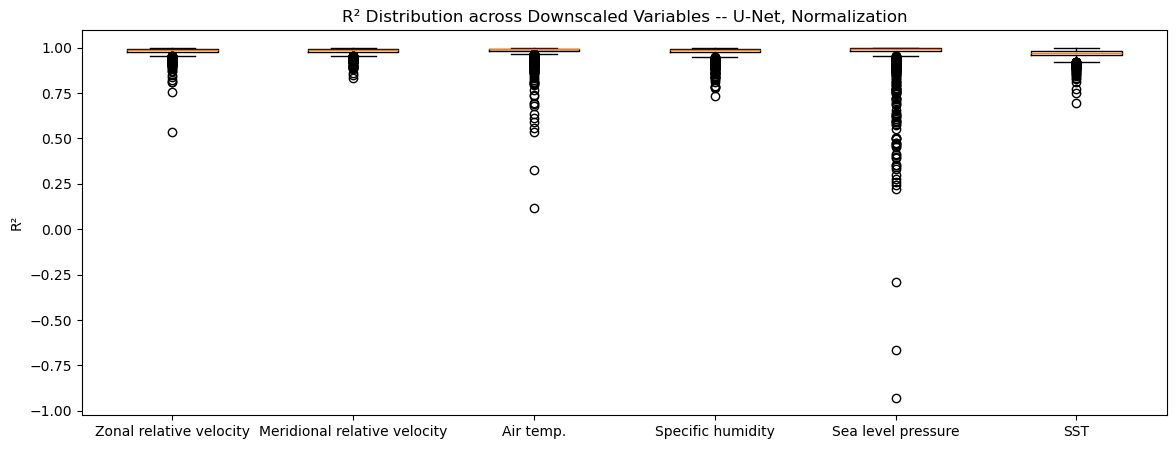

In [32]:
data = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

plt.figure(figsize=(14, 5))
plt.boxplot(data, vert=True)  # each array becomes a separate boxplot
plt.xticks([1, 2, 3, 4, 5, 6], ["Zonal relative velocity", "Meridional relative velocity", 
                                        "Air temp.", "Specific humidity", "Sea level pressure", "SST"])  # label each box
plt.ylabel("R²")
plt.title("R² Distribution across Downscaled Variables -- U-Net, Normalization")
plt.show()

In [33]:
# Suppose you have 6 arrays: a1, a2, ..., a6 (all same length)
arrays = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

# Stack into shape (6, N) and take mean over axis=0
mean_array = np.mean(np.stack(arrays, axis=0), axis=0)

# Find the max value and its index
max_val = np.max(mean_array)
max_idx = np.argmax(mean_array)

print(f"Max value = {max_val}, at index = {max_idx}")

Max value = 0.9945548971494039, at index = 174


In [34]:
# Find the min value and its index
min_val = np.min(mean_array)
min_idx = np.argmin(mean_array)

print(f"Min value = {min_val}, at index = {min_idx}")

Min value = 0.6506239275137583, at index = 168


In [35]:
# Make a Dataset
ds_unet_norm = xr.Dataset()

# Manually add variables
ds_unet_norm["u_rel_sr"] = (("time", "y", "x"), urel_sr_pred.values)
ds_unet_norm["v_rel_sr"] = (("time", "y", "x"), vrel_sr_pred.values)
ds_unet_norm["t_ref_sr"] = (("time", "y", "x"), tref_sr_pred.values)
ds_unet_norm["q_ref_sr"] = (("time", "y", "x"), qref_sr_pred.values)
ds_unet_norm["slp_sr"] = (("time", "y", "x"), slp_sr_pred.values)
ds_unet_norm["sst_sr"] = (("time", "y", "x"), sst_sr_pred.values)

ds_unet_norm["u_rel_hr"] = (("time", "y", "x"), urel_HR_test.values)
ds_unet_norm["v_rel_hr"] = (("time", "y", "x"), vrel_HR_test.values)
ds_unet_norm["t_ref_hr"] = (("time", "y", "x"), tref_HR_test.values)
ds_unet_norm["q_ref_hr"] = (("time", "y", "x"), qref_HR_test.values)
ds_unet_norm["slp_hr"] = (("time", "y", "x"), slp_HR_test.values)
ds_unet_norm["sst_hr"] = (("time", "y", "x"), sst_HR_test.values)

ds_unet_norm["u_rel_lr"] = (("time", "y", "x"), urel_LR_test)
ds_unet_norm["v_rel_lr"] = (("time", "y", "x"), vrel_LR_test)
ds_unet_norm["t_ref_lr"] = (("time", "y", "x"), tref_LR_test)
ds_unet_norm["q_ref_lr"] = (("time", "y", "x"), qref_LR_test)
ds_unet_norm["slp_lr"] = (("time", "y", "x"), slp_LR_test)
ds_unet_norm["sst_lr"] = (("time", "y", "x"), sst_LR_test)

print(ds_unet_norm)

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 1314, y: 150, x: 150)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    u_rel_sr  (time, y, x) float32 118MB -2.225 -2.625 -2.275 ... -0.1718 -0.36
    v_rel_sr  (time, y, x) float32 118MB 4.394 4.417 4.597 ... -0.641 -0.5935
    t_ref_sr  (time, y, x) float32 118MB 296.2 296.5 296.2 ... 279.6 279.7 280.1
    q_ref_sr  (time, y, x) float32 118MB 0.003742 0.00216 ... 0.01643 0.01638
    slp_sr    (time, y, x) float32 118MB 1.02e+05 1.022e+05 ... 1.009e+05
    sst_sr    (time, y, x) float32 118MB 292.9 292.6 292.3 ... 299.4 298.9 298.7
    ...        ...
    u_rel_lr  (time, y, x) float32 118MB -2.472 -2.484 -2.495 ... 0.15 0.1782
    v_rel_lr  (time, y, x) float32 118MB 4.606 4.592 4.577 ... -0.8337 -0.8004
    t_ref_lr  (time, y, x) float32 118MB 296.8 296.8 296.8 ... 280.0 280.0 280.0
    q_ref_lr  (time, y, x) float32 118MB 0.001641 0.001642 ... 0.01663 0.01664
    slp_lr    (time, y, x) float32 118MB 1.022e+05 1.02

In [36]:
ds_unet_norm.to_zarr("gs://leap-persistent/panalluri/unet_norm_fluxInputs_global.zarr", zarr_version=2)

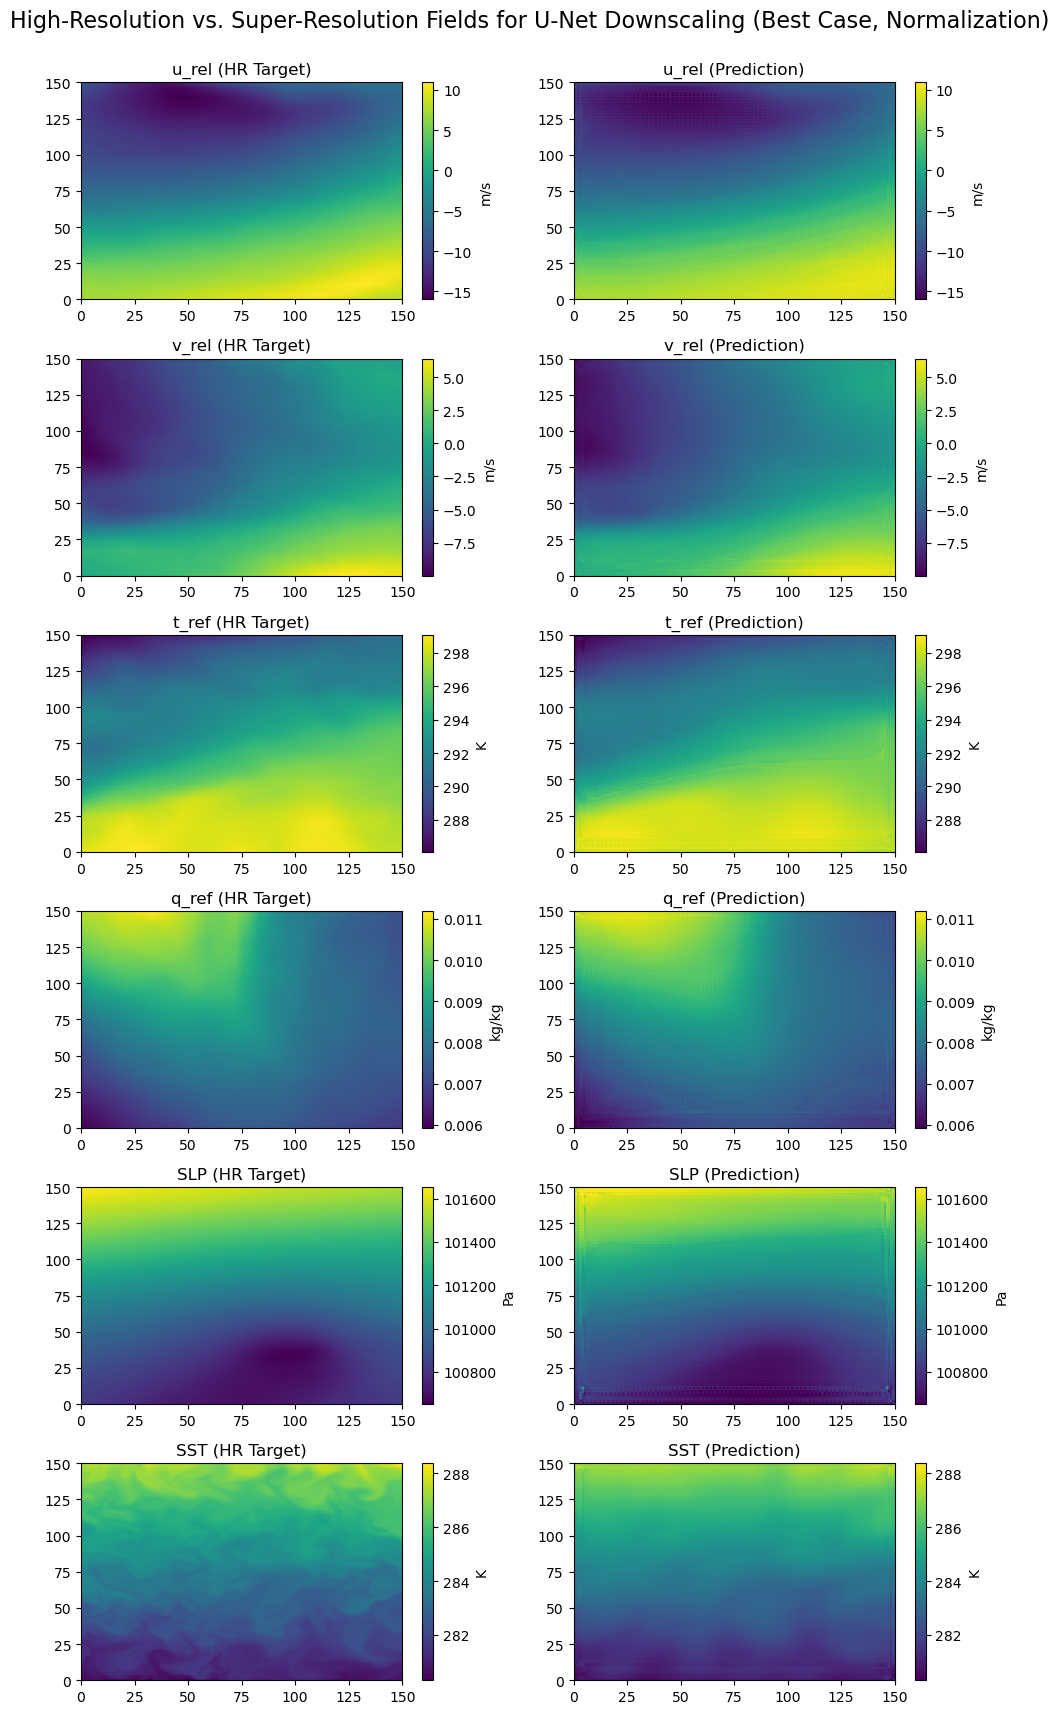

In [37]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[max_idx].min().values, vrel_HR_test[max_idx].min().values, tref_HR_test[max_idx].min().values,
         qref_HR_test[max_idx].min().values, slp_HR_test[max_idx].min().values, sst_HR_test[max_idx].min().values]
vmaxs = [urel_HR_test[max_idx].max().values, vrel_HR_test[max_idx].max().values, tref_HR_test[max_idx].max().values,
         qref_HR_test[max_idx].max().values, slp_HR_test[max_idx].max().values, sst_HR_test[max_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for U-Net Downscaling (Best Case, Normalization)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

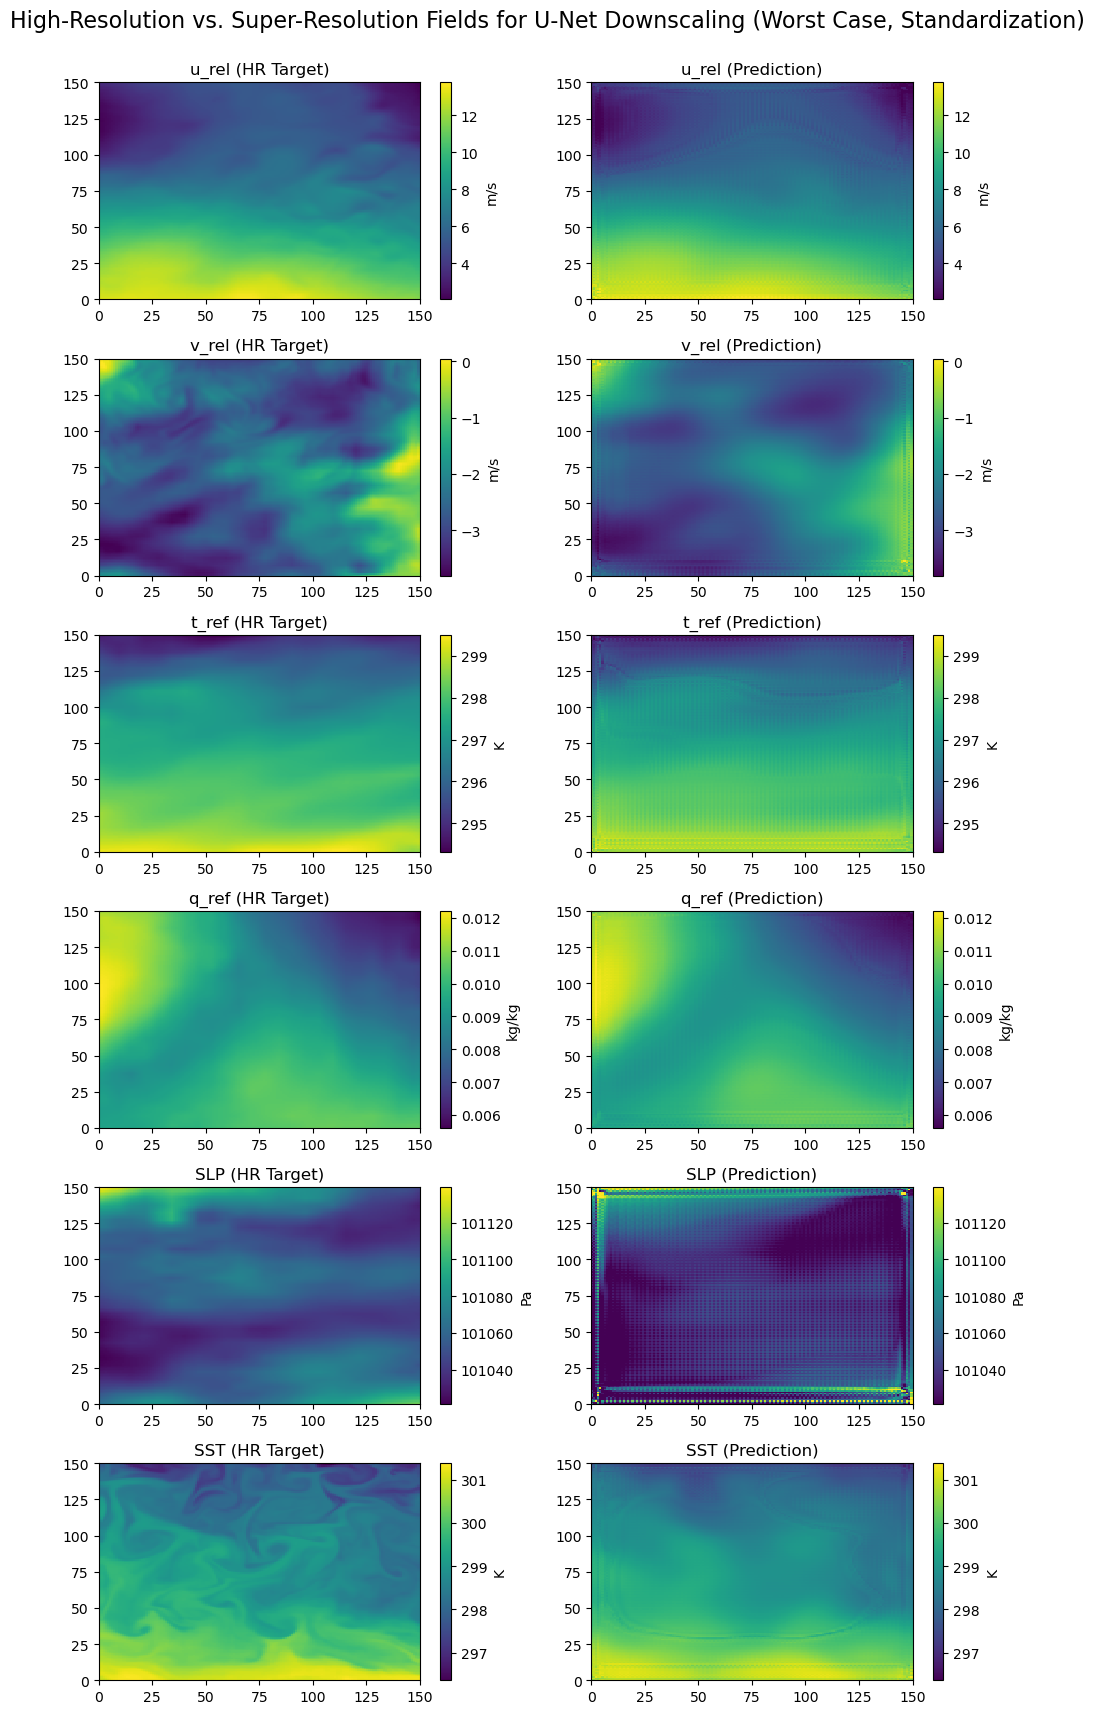

In [38]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[min_idx].min().values, vrel_HR_test[min_idx].min().values, tref_HR_test[min_idx].min().values,
         qref_HR_test[min_idx].min().values, slp_HR_test[min_idx].min().values, sst_HR_test[min_idx].min().values]
vmaxs = [urel_HR_test[min_idx].max().values, vrel_HR_test[min_idx].max().values, tref_HR_test[min_idx].max().values,
         qref_HR_test[min_idx].max().values, slp_HR_test[min_idx].max().values, sst_HR_test[min_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for U-Net Downscaling (Worst Case, Standardization)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# SGS HF Contribution Plots

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import aerobulk
from aerobulk import noskin

In [2]:
def r2(y_true, y_pred):
    
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - np.mean(yt)) ** 2)
    r2_scores = 1 - ss_res / ss_tot
    
    return r2_scores

In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

## Import data

In [4]:
ds_all = xr.open_dataset(
"gs://leap-persistent/panalluri/unet_norm_fluxInputs_global.zarr", engine="zarr", chunks={}
)
ds_all

<xarray.Dataset>
Dimensions:   (time: 1314, y: 150, x: 150)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    q_ref_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    q_ref_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    q_ref_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_hr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_lr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_sr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    ...        ...
    u_rel_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    u_rel_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    u_rel_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>

## Stats for all samples

In [5]:
ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_sr,
        ds_all.t_ref_sr,
        ds_all.q_ref_sr,
        ds_all.u_rel_sr,
        ds_all.v_rel_sr,
        slp=ds_all.slp_sr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_sr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_lr,
        ds_all.t_ref_lr,
        ds_all.q_ref_lr,
        ds_all.u_rel_lr,
        ds_all.v_rel_lr,
        slp=ds_all.slp_lr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_lr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_hr,
        ds_all.t_ref_hr,
        ds_all.q_ref_hr,
        ds_all.u_rel_hr,
        ds_all.v_rel_hr,
        slp=ds_all.slp_hr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_hr_all = qh + ql

In [6]:
# Make a Dataset
ds_heatflux = xr.Dataset()

# Manually add variables
ds_heatflux["heatflux_hr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_lr_all.values)
ds_heatflux["heatflux_lr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_hr_all.values)
ds_heatflux["heatflux_sr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_sr_all.values)

ds_heatflux

<xarray.Dataset>
Dimensions:      (time: 1314, yt_ocean: 150, xt_ocean: 150)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 -174.1 -173.4 ... -156.5
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 -190.5 -191.0 ... -165.2
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 -135.7 -158.5 ... -146.4

In [7]:
print("Filtering model")
heatflux_smooth = filter_inputs_dataset(ds_heatflux, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
heatflux_smooth

Filtering model


<xarray.Dataset>
Dimensions:      (time: 1314, yt_ocean: 150, xt_ocean: 150)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 -169.3 -170.7 ... -446.2
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 -180.4 -182.0 ... -474.4
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 -180.1 -181.6 ... -478.3
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [8]:
HF_SGS_all_pred = heatflux_smooth.heatflux_sr - heatflux_smooth.heatflux_lr
HF_SGS_all_true = heatflux_smooth.heatflux_hr - heatflux_smooth.heatflux_lr

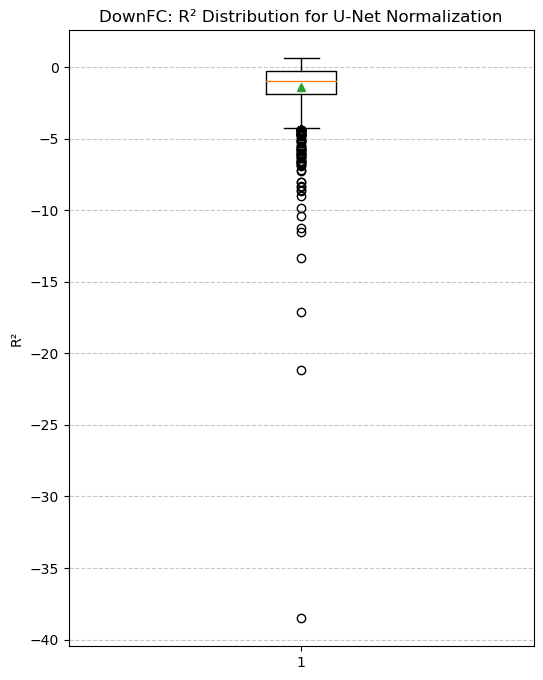

In [9]:
r2_all = r2_per_sample(HF_SGS_all_true.values, HF_SGS_all_pred.values)
plt.figure(figsize=(6, 8))
plt.boxplot(r2_all, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DownFC: R² Distribution for U-Net Normalization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Best case results (from SGS HF R2 values)

In [10]:
arr = r2_all

max_val = arr.max()        # get the minimum value
max_idx = arr.argmax()     # get the index of the minimum value

print("Maximum R2 value:", max_val)
print("Index of maximum:", max_idx)

Maximum R2 value: 0.613889406690085
Index of maximum: 893


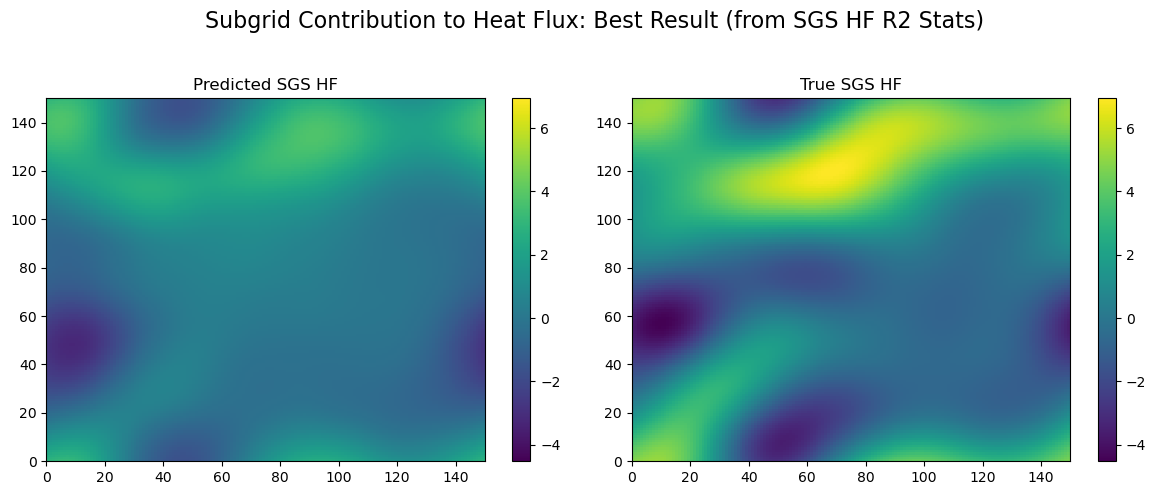

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx)
data2 = HF_SGS_all_true.isel(time=max_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Worst case results (from SGS HF R2 values)

In [12]:
arr = r2_all

min_val = arr.min()        # get the minimum value
min_idx = arr.argmin()     # get the index of the minimum value

print("Minimum R2 value:", min_val)
print("Index of minimum:", min_idx)

Minimum R2 value: -38.51473316802498
Index of minimum: 747


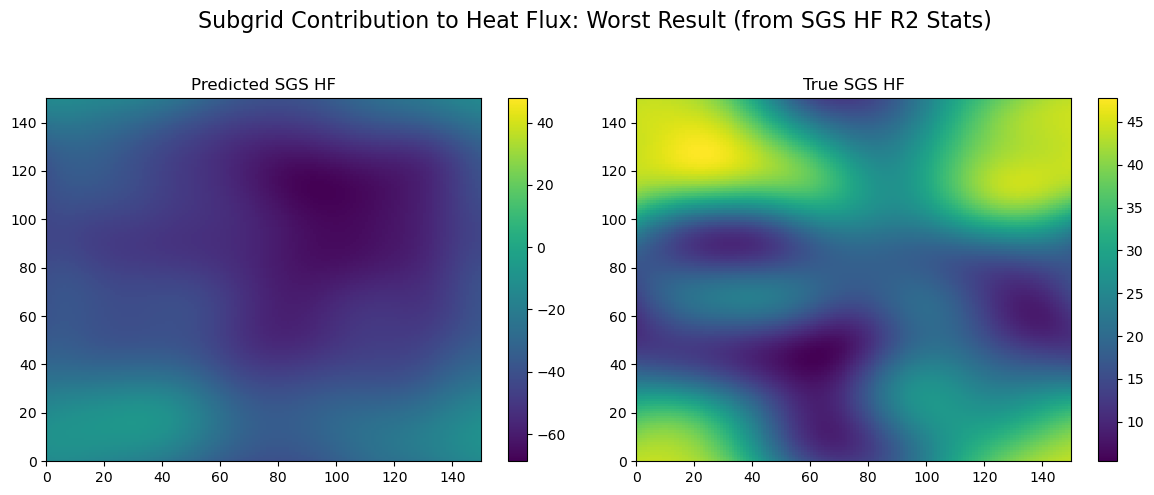

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx)
data2 = HF_SGS_all_true.isel(time=min_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2) #, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Best Case Results (from downscaling R2 values)

In [14]:
max_idx_down = 78
min_idx_down = 19

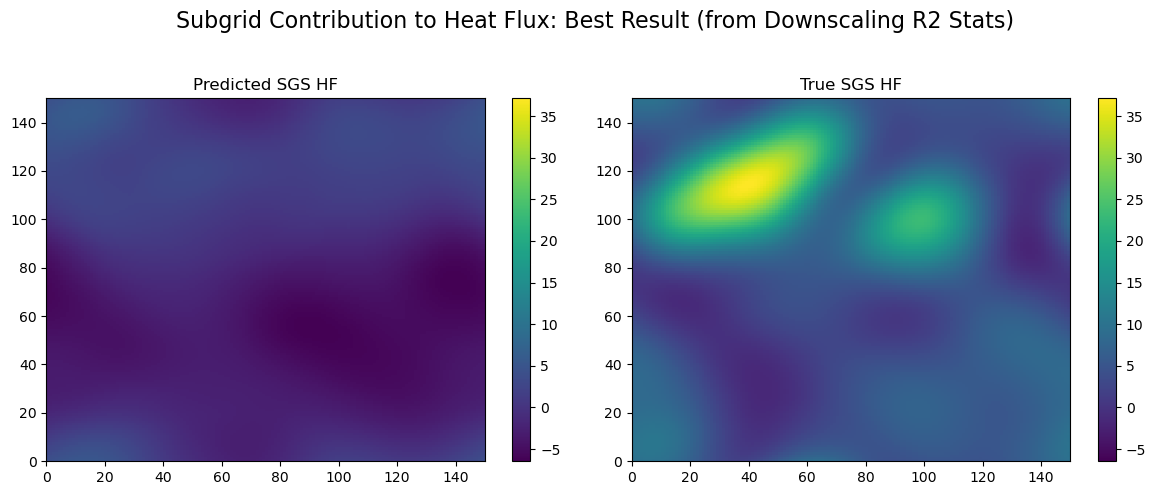

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [16]:
data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
r2(data1.values, data2.values)

-12.325854847027223

## Worst Case Results (from downscaling R2 values)

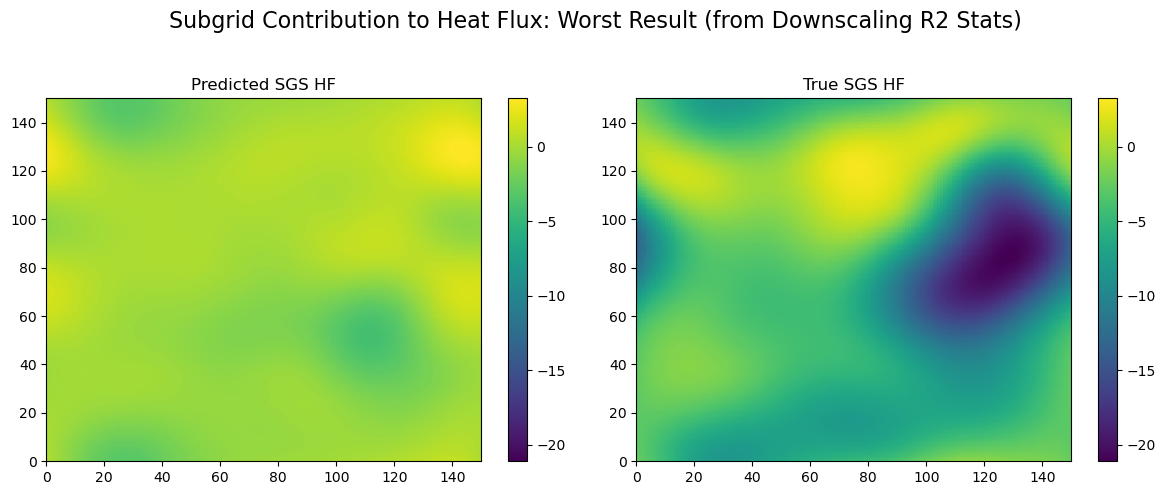

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [18]:
data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
r2(data1.values, data2.values)

-39.27277558239347